## 3️⃣ Statistical Inference & Feature Engineering
- ####  Copy code for Validation set

In [1]:
import warnings

# Load libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy as sp
from IPython.display import display
from yellowbrick.base import Visualizer
import geopy.distance
import pyarrow as pa
import fastparquet as fp
import os

# set random seed
np.random.seed(42)

<!-- # conda install gmaps -->

**1. Start the analysis by processing the training dataset based on the findings obtained in the Exploratory Data Analysis (EDA), e.g., by dealing with missing values and removing duplicates if necessary;**
- 💁‍♂️ Try to tailor the [datatype](https://pandas.pydata.org/docs/user_guide/basics.html#basics-dtypes) as much as possible.

In [2]:
# Load data: 
df_val = pd.read_csv("./data/data_val.csv")


In [4]:
#Remove NA and duplicates: 

# Given EDA showed only 0.05% missing values derived from target variable, and no duplicates detected
# It is safe to directly drop them from training sets 
df_val_cleaned = df_val.dropna().drop_duplicates() 
df_val_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 184 entries, 0 to 184
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Price    184 non-null    float64
 1   Address  184 non-null    object 
 2   Zip      184 non-null    object 
 3   Area     184 non-null    int64  
 4   Room     184 non-null    int64  
 5   Lon      184 non-null    float64
 6   Lat      184 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 11.5+ KB


In [5]:
df_val_cleaned.describe()

,Price,Area,Room,Lon,Lat
count,1.840000e+02,184.000000,184.000000,184.000000,184.000000
mean,6.296997e+05,95.005435,3.576087,4.891831,52.362853
std,4.580083e+05,45.791819,1.454097,0.056540,0.025100
min,2.100000e+05,25.000000,1.000000,4.644819,52.292324
25%,3.500000e+05,62.000000,3.000000,4.860384,52.350821
50%,4.750000e+05,85.000000,3.000000,4.883606,52.365560
75%,7.250000e+05,114.000000,4.000000,4.921270,52.378146
max,3.925000e+06,319.000000,9.000000,5.016555,52.423619


In [6]:
# Given exploratory analysis suggested several variables were right skewed,more importantly some variables are not at same scale,  
# suggesting need of log transformation, I first transformed these variables 
# additionally computed price per unit, as economically it might be more sensible to compare unit price (however same city may not be necessary)

df_val_cleaned[['log_price', 'log_area']] = np.log(df_val_cleaned[['Price', 'Area']])

df_val_cleaned['Price_m²']= df_val_cleaned['Price']/df_val_cleaned['Area']
df_val_cleaned['log_Price_m²']= np.log(df_val_cleaned['Price_m²'])


In [7]:
# create new column calculate distance to city centre 
# Assuming central station as the heart of city, in this way we can compute each houses distance to center point 

city_centre = (52.3791, 4.9003)  
df_val_cleaned['house_coord'] = list(zip(df_val_cleaned.Lat, df_val_cleaned.Lon))

df_val_cleaned['km_to_centre'] =  df_val_cleaned['house_coord'].apply(lambda x: geopy.distance.geodesic(x, city_centre).km)

In [8]:
df_val_cleaned.drop(columns=['house_coord'], axis=1, inplace=True)
df_val_cleaned.head(3)

,Price,Address,Zip,Area,Room,Lon,Lat,log_price,log_area,Price_m²,log_Price_m²,km_to_centre
0,425000.0,"Lamarckhof 11 I, Amsterdam",1098 TK,68,3,4.944251,52.352317,12.959844,4.219508,6250.000000,8.740337,4.224315
1,285000.0,"Kikkenstein 3534, Amsterdam",1104 TT,96,4,4.972596,52.317512,12.560244,4.564348,2968.750000,7.995896,8.440149
2,270000.0,"Papendrechtstraat 84, Amsterdam",1106 BR,84,3,4.976048,52.297850,12.506177,4.430817,3214.285714,8.075360,10.411294


In [9]:
# extract data from https://maps.amsterdam.nl/, and map train set to 9 boarder boroughs

from shapely.geometry import Point
import requests
import geopandas as gpd

url = "https://maps.amsterdam.nl/open_geodata/geojson_lnglat.php?KAARTLAAG=INDELING_STADSDEEL&THEMA=gebiedsindeling"
gdf_districts = gpd.read_file(requests.get(url).text)


geometry = [Point(xy) for xy in zip(df_val_cleaned.Lon, df_val_cleaned.Lat)]
df_val_cleaned_geo = gpd.GeoDataFrame(df_val_cleaned, geometry=geometry,crs="EPSG:4326")

df_val_cleaned_geo = gpd.sjoin(df_val_cleaned_geo,gdf_districts,  how='inner',op= 'intersects')

df_val_cleaned_geo.rename(columns={'Stadsdeel':'Borough', "index_right":"borough_id"}, inplace= True)

df_val_cleaned_geo.drop(columns=['geometry','Stadsdeelcode','Oppervlakte_m2'], inplace=True)
df_val_cleaned_geo.head(3)

/opt/anaconda3/envs/Anacoda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3472: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,Price,Address,Zip,Area,Room,Lon,Lat,log_price,log_area,Price_m²,log_Price_m²,km_to_centre,borough_id,Borough
0,425000.0,"Lamarckhof 11 I, Amsterdam",1098 TK,68,3,4.944251,52.352317,12.959844,4.219508,6250.000000,8.740337,4.224315,1,Oost
5,600000.0,"IJburglaan 1445, Amsterdam",1087 KH,132,4,5.000330,52.352820,13.304685,4.882802,4545.454545,8.421883,7.414713,1,Oost
6,348738.0,"Quashibastraat, Amsterdam",1087 VS,79,4,5.016555,52.350513,12.762076,4.369448,4414.405063,8.392628,8.534108,1,Oost


In [10]:
house_count_by_borough = pd.DataFrame(df_val_cleaned_geo[['borough_id','Borough']].value_counts())
house_count_by_borough.sort_values(by='borough_id')

,,0
borough_id,Borough,
0,Centrum,30
1,Oost,22
3,Nieuw-West,23
4,Zuidoost,15
5,Noord,21
6,West,43
7,Weesp,1
8,Zuid,28


In [11]:
# recreate house type categorical variable
df_val_cleaned_geo['house_type']=pd.qcut(df_val_cleaned_geo['Room'], q=2,labels=['family_1-3', 'luxury_4+'],precision=0)
df_val_cleaned_geo['house_type'].value_counts()

family_1-3    110
luxury_4+      73
Name: house_type, dtype: int64

In [13]:
# recreate house size categorical variable--> small: (20.0, 68.0], medium: (68.0, 100.0] , large: (100.0, 497.0]
df_val_cleaned_geo['house_size_cat']= pd.qcut(df_val_cleaned_geo['Area'], q=3,labels=['small', 'medium', 'large'], precision=0)
df_val_cleaned_geo['house_size_cat'].value_counts()

small     63
large     61
medium    59
Name: house_size_cat, dtype: int64

In [14]:
df_val_cleaned_geo.head(3)

,Price,Address,Zip,Area,Room,Lon,Lat,log_price,log_area,Price_m²,log_Price_m²,km_to_centre,borough_id,Borough,house_type,house_size_cat
0,425000.0,"Lamarckhof 11 I, Amsterdam",1098 TK,68,3,4.944251,52.352317,12.959844,4.219508,6250.000000,8.740337,4.224315,1,Oost,family_1-3,small
5,600000.0,"IJburglaan 1445, Amsterdam",1087 KH,132,4,5.000330,52.352820,13.304685,4.882802,4545.454545,8.421883,7.414713,1,Oost,luxury_4+,large
6,348738.0,"Quashibastraat, Amsterdam",1087 VS,79,4,5.016555,52.350513,12.762076,4.369448,4414.405063,8.392628,8.534108,1,Oost,luxury_4+,medium


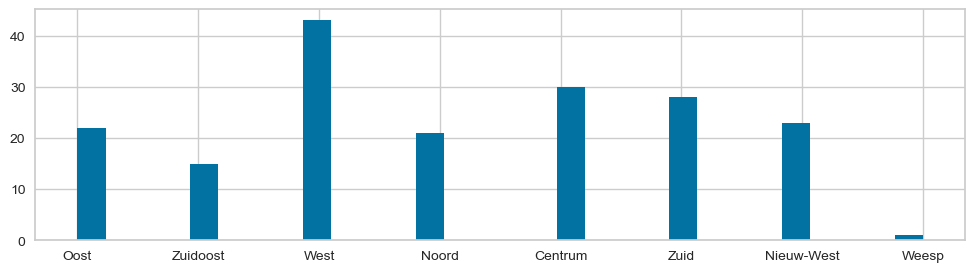

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
df_val_cleaned_geo.Borough.hist( bins = 30,figsize=(12,3))
plt.show()

**2. Study the relationship between variables using conventional statistical tools, namely:** 

- **a.** $\chi^{2}$ ([chi-square](https://www.investopedia.com/terms/c/chi-square-statistic.asp)) between two **Nominal** variables;
- **b.** $\chi^{2}$ or [Spearman’s rank](https://statistics.laerd.com/statistical-guides/spearmans-rank-order-correlation-statistical-guide.php) correlation analysis between two **Ordinal** variables;
- **c.** [Correlation](https://www.statisticshowto.com/probability-and-statistics/correlation-analysis/) analysis for both **Discrete** and **Continuous** variables;
- **d.** An appropriate version of the [t-test](https://www.investopedia.com/terms/t/t-test.asp) or [analysis of variance](https://www.investopedia.com/terms/a/anova.asp) (ANOVA) to assess the relationship between **Numerical** and **Categorical** variables.   

💁‍♀️ Look closely at the relationship between the dependent variable, i.e., the target and the independent variables, i.e., the features, as they will provide an insight into candidate predictors. 

💁‍♂️ Whenever possible, visualize the variables to assess whether the results coming from the statistical test are driven by outliers or imbalanced groups.

👷 Transform and/or construct new features and apply appropriate statistical tests.



**a.** Analysis of **Nominal** features

In [16]:
# Given the above has already transformed the original data frame into various categorical features, 
# I thus categorise the response variables into equal-sized bins using the qcut() function.
df_val_cleaned_geo['Price_range'] = pd.qcut(df_val_cleaned_geo['Price'], q=4, precision=0)
df_val_cleaned_geo['Price_range'].value_counts().sort_index()

(209999.0, 350000.0]     47
(350000.0, 475000.0]     47
(475000.0, 725000.0]     45
(725000.0, 3925000.0]    44
Name: Price_range, dtype: int64

In [17]:
display(df_val_cleaned_geo.groupby("Price_range")[["log_area", "Room"]].mean())

display(df_val_cleaned_geo.groupby("Price_range")[["log_area", "Room"]].std())

,log_area,Room
Price_range,,
"(209999.0, 350000.0]",4.134564,2.914894
"(350000.0, 475000.0]",4.177801,2.851064
"(475000.0, 725000.0]",4.549795,3.800000
"(725000.0, 3925000.0]",4.968530,4.750000


,log_area,Room
Price_range,,
"(209999.0, 350000.0]",0.377479,0.996293
"(350000.0, 475000.0]",0.280745,0.884129
"(475000.0, 725000.0]",0.271000,1.140175
"(725000.0, 3925000.0]",0.290051,1.727008


In [18]:
# generating all contigency tables in excel tabs saving each output 
# By focusing on exploring relationships between similar IVs; as well as each categorical IV with the DV

import openpyxl

# Define each contigency table of interest
contigency_table1 = pd.crosstab(df_val_cleaned_geo['house_type'],df_val_cleaned_geo['house_size_cat']) 
contigency_table2 = pd.crosstab(df_val_cleaned_geo['house_type'],df_val_cleaned_geo['Price_range']) 
contigency_table3 = pd.crosstab(df_val_cleaned_geo['house_size_cat'],df_val_cleaned_geo['Price_range']) 
contigency_table4 = pd.crosstab(df_val_cleaned_geo['Borough'],df_val_cleaned_geo['Price_range']) 

#create a excel writer object that stores each contigency table in a different tab within same file
with pd.ExcelWriter("data/contigency_tables_valset.xlsx") as writer:
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    contigency_table1.to_excel(writer, sheet_name="Sheet1", index=True)
    contigency_table2.to_excel(writer, sheet_name="Sheet2", index=True)
    contigency_table3.to_excel(writer, sheet_name="Sheet3", index=True)
    contigency_table4.to_excel(writer, sheet_name='Sheet4', index=True)


In [19]:
# Read the excel file just created which contains all the contigency tables
xls = pd.ExcelFile('data/contigency_tables_valset.xlsx')

#Check list of all sheets in the file
xls.sheet_names

# to read all sheets and store the output into a dictionary, so that later can manipulate these contingeny tables
# from one uniformed data structure 
sheet_to_df_map = {}
for sheet_name in xls.sheet_names:
    sheet_to_df_map[sheet_name] = xls.parse(sheet_name, index_col=0)

# inspect mapped dictionary's data type and display each contigency table from dictionary 
display(list(sheet_to_df_map.values())[0])
display(list(sheet_to_df_map.values())[1])
display(list(sheet_to_df_map.values())[2])
display(list(sheet_to_df_map.values())[3])

,small,medium,large
house_type,,,
family_1-3,62,38,10
luxury_4+,1,21,51


,"(209999.0, 350000.0]","(350000.0, 475000.0]","(475000.0, 725000.0]","(725000.0, 3925000.0]"
house_type,,,,
family_1-3,36,39,22,13
luxury_4+,11,8,23,31


,"(209999.0, 350000.0]","(350000.0, 475000.0]","(475000.0, 725000.0]","(725000.0, 3925000.0]"
house_size_cat,,,,
small,26,31,6,0
medium,17,13,24,5
large,4,3,15,39


,"(209999.0, 350000.0]","(350000.0, 475000.0]","(475000.0, 725000.0]","(725000.0, 3925000.0]"
Borough,,,,
Centrum,1,6,8,15
Nieuw-West,7,6,8,2
Noord,9,3,5,4
Oost,2,7,9,4
Weesp,0,0,1,0
West,12,15,10,6
Zuid,1,10,4,13
Zuidoost,15,0,0,0


In [20]:
from scipy.stats import chi2_contingency

# Create empty df to store results from chi-square tests
chi_res = pd.DataFrame(columns=['Statistic','p-value','DoF','Result'])
alpha=0.05

# Looping through each contingency table to perform chi-square test
for i, value in enumerate(sheet_to_df_map):
    c, p, dof, expected_freq = chi2_contingency(list(sheet_to_df_map.values())[i], correction=True)
    if p <= alpha:
        pp = 'Dependent (reject H0)'
    else:
        pp = 'Independent (fail to reject H0)'
    lst = [round(c,2), round(p,4), dof, pp]
    chi_res.loc[len(chi_res)] = lst

# Tidy up final test result table 
chi_res.reset_index(inplace = True)
chi_res.rename(columns = {'index':'Contigency_Table'}, inplace = True)

chi_res['Contigency_Table'].replace({0: "house_type & house_size_cat", 
                                     1: "Price_range & house_type",
                                     2: "Price_range & house_size_cat",
                                     3: " Price_range & Borough"
                                     },inplace=True)

chi_res.set_index('Contigency_Table', inplace = True)
chi_res

,Statistic,p-value,DoF,Result
Contigency_Table,,,,
house_type & house_size_cat,87.62,0.0,2,Dependent (reject H0)
Price_range & house_type,35.08,0.0,3,Dependent (reject H0)
Price_range & house_size_cat,112.49,0.0,6,Dependent (reject H0)
Price_range & Borough,90.47,0.0,21,Dependent (reject H0)


<!-- https://neuhofmo.github.io/chi-square-and-post-hoc-in-python/ -->

- Examined the computed variables derived from area, room, and geolocation; results showed these catgeorical variables were dependent on each other 

**b.** Analysis of **Ordinal** features

* No ordinal features from raw train set, although some of featured ordinal variables has been tested above  

**c.** Analysis of **Discrete** and **Continuous** features

In [21]:
# tidy up and remove columns that were duplicating
res_dat = df_val_cleaned_geo.drop(columns=['Price', 'Area','Price_m²','Address','Zip','Lon','Lat','log_Price_m²','borough_id','Price_range'], axis=1 ) #remove raw data column before log transformation
res_dat.columns

Index(['Room', 'log_price', 'log_area', 'km_to_centre', 'Borough',
       'house_type', 'house_size_cat'],
      dtype='object')

/var/folders/m6/h_c6j54j54723kby9c10j_0m0000gn/T/ipykernel_32111/1786821713.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix = res_dat.corr().round(2)


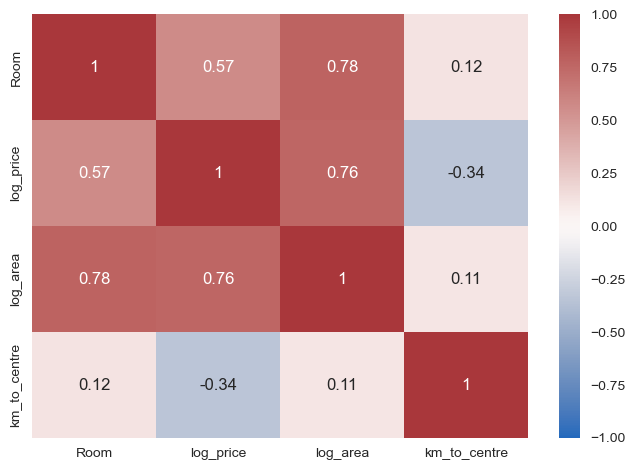

In [22]:
# display(res_dat.corr())

# visualise correlation matrix among variables 
matrix = res_dat.corr().round(2)
# mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')#, mask=mask)
plt.show()

- Consistent with above chi-square test, Room and log_area deems to be dependent with each other, hence showing high correlations 

- There is also a negative correlation between distance to centre with log_price, indicating the further from city centre is negatively associated to log_price 

In [23]:
#specify predictor and outcomes variables in the model 
y = res_dat["log_price"]
x = res_dat.drop(columns=['log_price'], axis=1 ) 
x.columns


Index(['Room', 'log_area', 'km_to_centre', 'Borough', 'house_type',
       'house_size_cat'],
      dtype='object')

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

numerical = x.select_dtypes([np.int64, np.float64])

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = numerical.columns
vif_data["VIF"] = [variance_inflation_factor(numerical.values, i)
                          for i in range(len(numerical.columns))]

vif_data

,feature,VIF
0,Room,10.766963
1,log_area,13.401861
2,km_to_centre,3.669260


In [25]:
# Evidence supporting H1a, H1c
import statsmodels.formula.api as smf
lm = smf.ols("log_price ~ log_area + Room + km_to_centre", data= res_dat)
model = lm.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     199.8
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           6.91e-57
Time:                        00:14:00   Log-Likelihood:                -11.648
No. Observations:                 183   AIC:                             31.30
Df Residuals:                     179   BIC:                             44.13
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        9.1726      0.250     36.743   

In [27]:
# Reject H1b 
import statsmodels.formula.api as smf
lm = smf.ols("log_price ~ log_area +  km_to_centre", data= res_dat)
model = lm.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     300.7
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           4.17e-58
Time:                        00:14:38   Log-Likelihood:                -11.821
No. Observations:                 183   AIC:                             29.64
Df Residuals:                     180   BIC:                             39.27
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        9.2661      0.190     48.667   

In [26]:
# Reject H1b 
import statsmodels.formula.api as smf
lm = smf.ols("log_price ~ log_area + house_type + km_to_centre", data= res_dat)
model = lm.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     203.6
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           1.91e-57
Time:                        00:14:13   Log-Likelihood:                -10.332
No. Observations:                 183   AIC:                             28.66
Df Residuals:                     179   BIC:                             41.50
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

- VIF detects multicollinearity in regression analysis. when including all numeric varibles in the cleaned train set, room and log_area has been all above thredsholds (i.e., >5)

- In the above regression, room is not statistically significant, and given it is highly correlated with log_area, I thus remove this variable from the model. After removing it, the vif score indicated that no multicollinearity has been detected 

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

numerical = x[['log_area','km_to_centre']]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = numerical.columns
vif_data["VIF"] = [variance_inflation_factor(numerical.values, i)
                          for i in range(len(numerical.columns))]

vif_data

,feature,VIF
0,log_area,3.669219
1,km_to_centre,3.669219


In [29]:
res_dat.columns

Index(['Room', 'log_price', 'log_area', 'km_to_centre', 'Borough',
       'house_type', 'house_size_cat'],
      dtype='object')

In [30]:
# Final model selection 
import statsmodels.formula.api as smf
# lm = smf.ols("log_price ~  km_to_centre+ log_area", data= res_dat)

lm = smf.ols("log_price ~  km_to_centre+ log_area +Borough", data= res_dat)
model = lm.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     103.4
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           7.88e-65
Time:                        00:14:55   Log-Likelihood:                 23.378
No. Observations:                 183   AIC:                            -26.76
Df Residuals:                     173   BIC:                             5.339
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 9.22

- Also tried with mixed effects model with random intercept (below commented) to explore whether the relationship between log_price, distance to centre and log_area were varying across different borough clusters. Results showed not the case  

Text(0.5, 1.0, 'Avg log price by Borough')

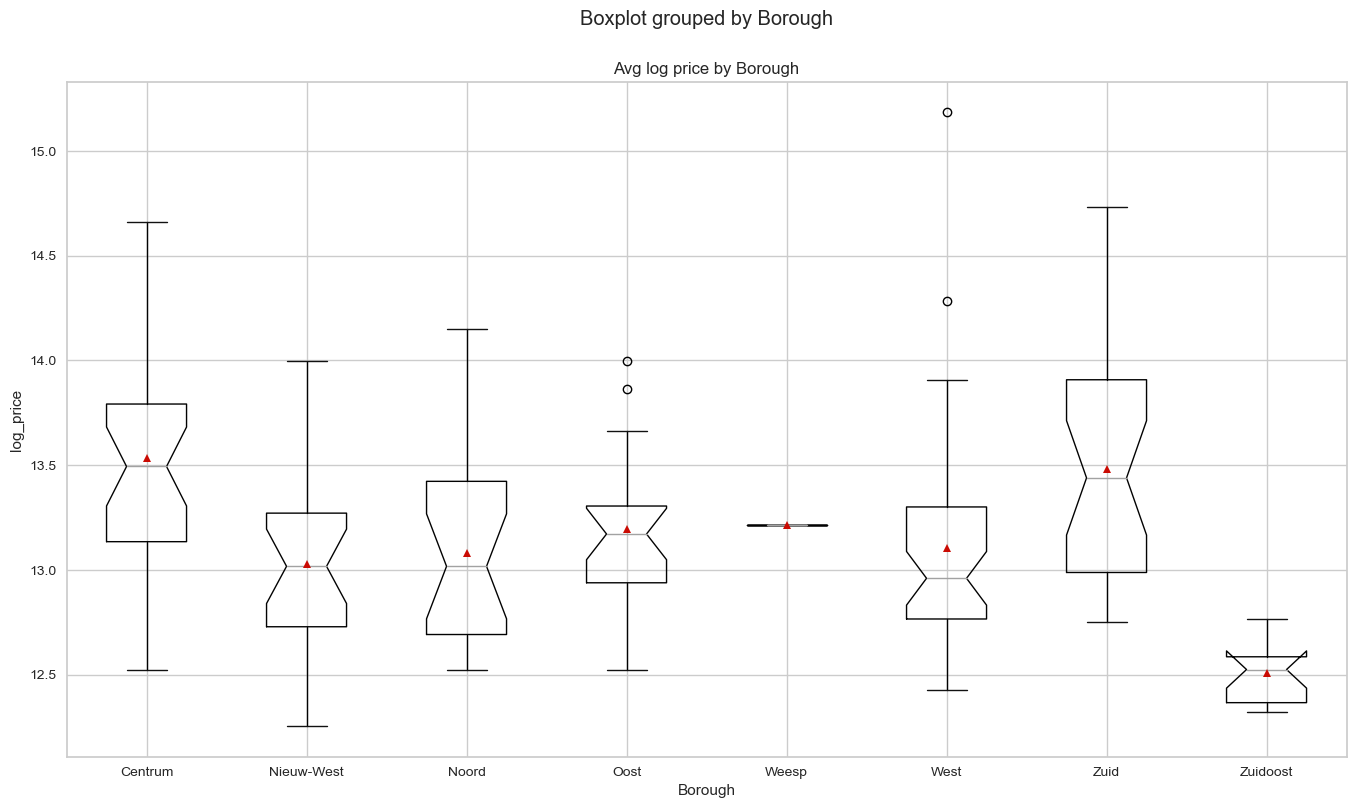

In [31]:
boxplot = res_dat.boxplot(["log_price"], by = ["Borough"],
                     figsize = (16, 9),
                     showmeans = True,
                     notch = True)

boxplot.set_xlabel("Borough")
boxplot.set_ylabel("log_price")
boxplot.set_title('Avg log price by Borough')

In [32]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

md = smf.mixedlm("log_price ~  log_area + km_to_centre +C(Borough)", res_dat, groups=res_dat["Borough"])
mdf = md.fit()
print(mdf.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      log_price
No. Observations:      183          Method:                  REML     
No. Groups:            8            Scale:                   0.0480   
Min. group size:       1            Log-Likelihood:          1.4854   
Max. group size:       43           Converged:               Yes      
Mean group size:       22.9                                           
----------------------------------------------------------------------
                         Coef.    Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                 9.223       0.282 32.715 0.000  8.671  9.776
C(Borough)[T.Nieuw-West] -0.278       0.324 -0.858 0.391 -0.914  0.357
C(Borough)[T.Noord]      -0.349       0.317 -1.100 0.271 -0.970  0.273
C(Borough)[T.Oost]       -0.089       0.320 -0.277 0.782 -0.716  0.539
C(Borough)[T.Weesp]    

**3. Identify outliers and points of high leverage and re-run statistical tests to assess their impact.** 

Check this [article](https://online.stat.psu.edu/stat462/node/170/#:~:text=In%20short%3A,is%20particularly%20high%20or%20low.) to understand the difference between **outliers** and **high-leverage points**.

- [Cook's distance](https://rpubs.com/DragonflyStats/Cooks-Distance) is a commonly used estimate of the influence of a data point when performing least squares regression analysis. Below section relied on Cook's distance method to detect influential cases. 

<!-- (https://towardsdatascience.com/identifying-outliers-in-linear-regression-cooks-distance-9e212e9136a#:~:text=Cook's%20Distance%20is%20an%20estimate,the%20ith%20observation%20is%20removed.) -->


In [33]:
res_dat.columns

Index(['Room', 'log_price', 'log_area', 'km_to_centre', 'Borough',
       'house_type', 'house_size_cat'],
      dtype='object')

Index(['Room', 'log_price', 'log_area', 'km_to_centre'], dtype='object')


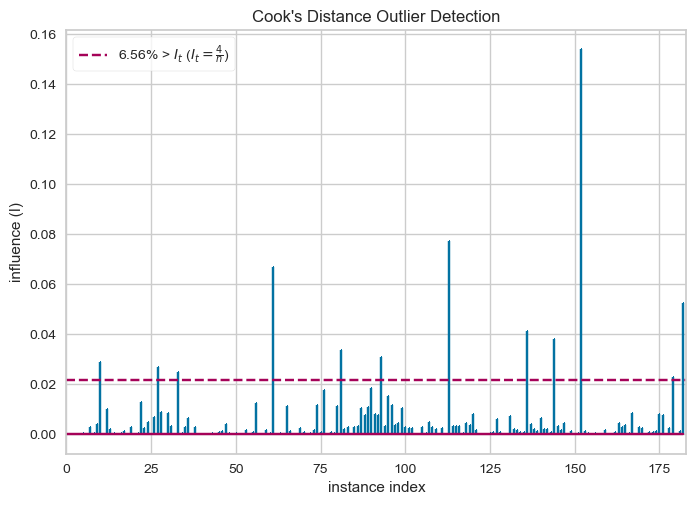

<Axes: title={'center': "Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [34]:
# https://lymielynn.medium.com/a-little-closer-to-cooks-distance-e8cc923a3250
# https://stackoverflow.com/questions/51390196/how-to-calculate-cooks-distance-dffits-using-python-statsmodel 
# https://www.scikit-yb.org/en/latest/_modules/yellowbrick/regressor/influence.html?highlight=cook%27s%20distance

from yellowbrick.regressor import CooksDistance

df_num = res_dat.select_dtypes([int, float])
# df_num = df_num.drop(columns=["Room"], axis= 1)

X = df_num.drop(columns=["log_price"],axis=1)
y = res_dat['log_price']

visualizer = CooksDistance()
visualizer.fit(X, y)

print(df_num.columns)
visualizer.show()



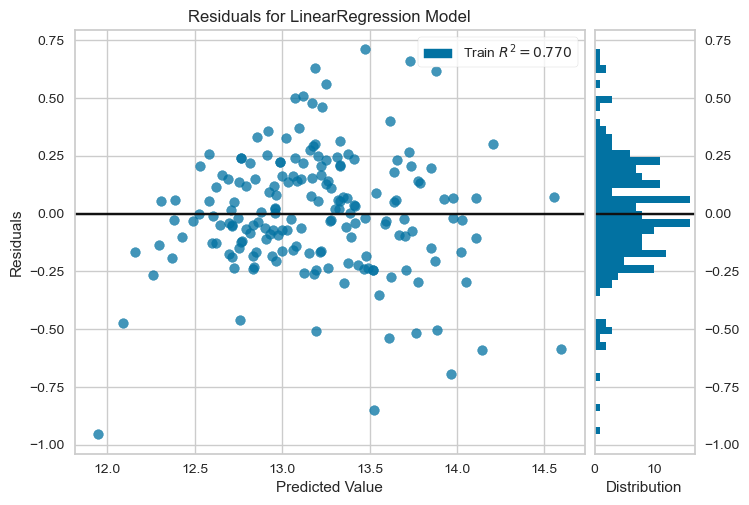

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [35]:
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import ResidualsPlot

model = LinearRegression()
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit(X, y)
visualizer_residuals.show()

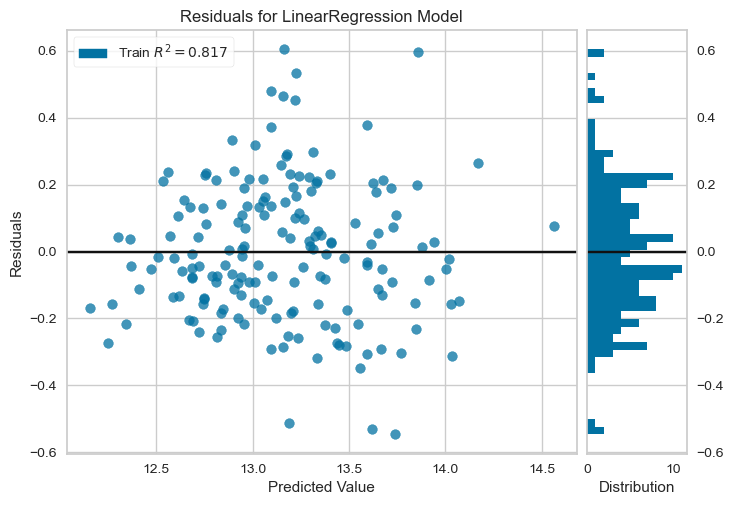

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [36]:
i_less_influential = (visualizer.distance_ <= visualizer.influence_threshold_)
X_li, y_li = X[i_less_influential], y[i_less_influential]

model = LinearRegression()
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit(X_li, y_li)
visualizer_residuals.show()

In [37]:
# Display influential cases 
df_val_cleaned_geo['influential'] = (visualizer.distance_ > visualizer.influence_threshold_)
df_val_cleaned_geo['infl_distance']=visualizer.distance_

print(f"There are {len(df_val_cleaned_geo[df_val_cleaned_geo['influential']==True])} influential cases detected from train set")

df_influential = df_val_cleaned_geo[df_val_cleaned_geo['influential']==True].sort_values(by='infl_distance', ascending= False)

display(df_influential.sample(3))


There are 12 influential cases detected from train set


,Price,Address,Zip,Area,Room,Lon,Lat,log_price,log_area,Price_m²,log_Price_m²,km_to_centre,borough_id,Borough,house_type,house_size_cat,Price_range,influential,infl_distance
123,275000.0,"Tefelenstraat 82, Amsterdam",1107 SM,111,5,4.970438,52.294244,12.524526,4.709530,2477.477477,7.814996,10.583536,4,Zuidoost,luxury_4+,large,"(209999.0, 350000.0]",True,0.024875
41,289500.0,"Gouden Leeuw 930, Amsterdam",1103 KW,108,5,4.974531,52.325473,12.575911,4.682131,2680.555556,7.893779,7.822477,4,Zuidoost,luxury_4+,large,"(209999.0, 350000.0]",True,0.026843
111,1775000.0,"Valeriusstraat 148 Hs, Amsterdam",1075 GE,177,9,4.865595,52.353408,14.389311,5.176150,10028.248588,9.213161,3.709640,8,Zuid,luxury_4+,large,"(725000.0, 3925000.0]",True,0.153876


- Cook's distance results indicated with and without removal of influential cases does not change much the explainability of the model, hence we can safely consider the train set does not contain any influential cases. 

- See this [link](https://towardsdatascience.com/are-you-using-feature-distributions-to-detect-outliers-48e2ae3309) for other ways detecting influential cases 

**5. If new features are created, save a new dataframe, ideally in [parquet](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_parquet.html) format, to retain metadata information.**

💁‍♂️ If you also have the validation set, apply the same transformations and save an additional dataframe.

ℹ️ `DataFrame.to_parquet()` requires [pyarrow](https://pypi.org/project/pyarrow/) and [fastparquet](https://pypi.org/project/fastparquet/) libraries.

In [38]:
import pyarrow as pa
import pyarrow.parquet as pq
import fastparquet as fp
import platform

print('Python: ', platform.python_version())
print('pandas: ', pd.__version__)
print('pyarrow: ', pa.__version__)


Python:  3.10.8
pandas:  1.5.3
pyarrow:  12.0.1


In [39]:
# store transformed data into parquet file
res_dat.to_parquet('data/transformed_val_set.parquet.gzip', compression='gzip')

In [40]:
import pyarrow.parquet as pq
import os

DATA_DIR = "data"
FILENAME = "transformed_val_set.parquet.gzip"

# Extract transformed_train_set.parquet.gzip
transformed_val_set = pd.read_parquet(
                                        os.path.join(DATA_DIR, FILENAME),
                                        engine='pyarrow')

transformed_val_set.head(3)

,Room,log_price,log_area,km_to_centre,Borough,house_type,house_size_cat
0,3,12.959844,4.219508,4.224315,Oost,family_1-3,small
5,4,13.304685,4.882802,7.414713,Oost,luxury_4+,large
6,4,12.762076,4.369448,8.534108,Oost,luxury_4+,medium


In [52]:
# Overwrite table schema for the feature engineered training set with customised specifications

transformed_val_set_schema = pa.schema([
     pa.field("Room", pa.int64(), metadata={"Description": "Number of rooms at residence, 1-14",
                                            "Calculation": "No",
                                            "Method": "Used as it is from source",
                                            "Data lineage": "data_val.csv",
                                            "Value": "1 to 9"
                                        }),
     
     pa.field("log_price", pa.float64(), metadata={"Description": "Transformed residential price in Euros from y to log(y)",
                                                  "Calculation": "Yes",
                                                  "Method": "log(y)",
                                                  "Data lineage": "data_val.csv",
                                                  "Value": "log(2.100000e+05) to log(3.925000e+06)"
                                               }),
     
     pa.field("log_area", pa.float64(), metadata={"Description": "Transformed residential area in square meters from x to log(x)",
                                                  "Calculation": "Yes",
                                                  "Method": "log(x)",
                                                  "Data lineage": "data_val.csv",
                                                  "Value": "log(25) to log(319)"
                                              }),
     
     pa.field("km_to_centre", pa.float64(), metadata={"Description":"Distance in kilometers from residence to Amsterdam Centraal Station\
                                                      (point reference proxy for city centre)",
                                                      "Calculation": "Yes",
                                                      "Method": "geopy.distance.geodesic by coordinates(Lat,Lon) and (52.379189, 4.899431)",
                                                      "Data lineage": "data_val.csv",
                                                      "Value": "0.61 to 11.43"
                                                  }),
     
     pa.field("Borough", pa.string(), metadata={"Description":"Amsterdam borough where residence is located",
                                                "Calculation": "Yes",
                                                "Method": "GeoPandas.sjoin by coordinates (Lon,Lat) and geometry",
                                                "Data lineage": "https://maps.amsterdam.nl/open_geodata/ -> Stadsdelen.shp",
                                                "Value": "Centrum, Oost, Nieuw-West, Zuidoost, Noord, West, Weesp, Zuid"
                                              }),
     
     pa.field("house_type", pa.string(),  metadata={"Description": "Type of residence base on number of rooms",
                                                    "Calculation": "No",
                                                    "Method": "Manual, qcut based on room count",
                                                    "Data lineage": "data_val.csv",
                                                    "Value": "'family_1-3'(110),'luxury_4+'(73)"
                                                    }),                                                
     
     pa.field("house_size_cat", pa.string(),  metadata={"Description": "Categorisation of house size based on Area (raw square meters)",
                                                        "Calculation": "No",
                                                        "Method": "Manual, qcut based on Area",
                                                        "Data lineage": "data_val.csv",
                                                        "Value": " 'Small'(63)->(24.0, 69.0], 'Medium'(59)->(69.0, 106.0],\
                                                        'Large'(61)->(106.0, 319.0]"})
     ],     
                                         
     metadata={"Dataset Description": "Feature engineered validation set for baseline model building", 
               "Dataset Name": "Amsterdam House Price Prediction feature engineered validation set",
               "Data lineage": "R3_statistical_inference_validation_copy.ipynb",
               "Data source": "https://www.kaggle.com/datasets/thomasnibb/amsterdam-house-price-prediction"
            }
)


In [53]:
# Read customised table schema from transformed_train_set.parquet.gzip 
print(transformed_val_set_schema)

Room: int64
  -- field metadata --
  Description: 'Number of rooms at residence, 1-14'
  Calculation: 'No'
  Method: 'Used as it is from source'
  Data lineage: 'data_val.csv'
  Value: '1 to 9'
log_price: double
  -- field metadata --
  Description: 'Transformed residential price in Euros from y to log(y)'
  Calculation: 'Yes'
  Method: 'log(y)'
  Data lineage: 'data_val.csv'
  Value: 'log(2.100000e+05) to log(3.925000e+06)'
log_area: double
  -- field metadata --
  Description: 'Transformed residential area in square meters from x to l' + 5
  Calculation: 'Yes'
  Method: 'log(x)'
  Data lineage: 'data_val.csv'
  Value: 'log(25) to log(319)'
km_to_centre: double
  -- field metadata --
  Description: 'Distance in kilometers from residence to Amsterdam Centra' + 103
  Calculation: 'Yes'
  Method: 'geopy.distance.geodesic by coordinates(Lat,Lon) and (52.379189' + 11
  Data lineage: 'data_val.csv'
  Value: '0.61 to 11.43'
Borough: string
  -- field metadata --
  Description: 'Amsterdam bor